# Exploratory Data Analysis

In this notebook we'll do some exploratory data analysis over our dataset. However, since we don't have our features created yet, we cannot do much at this point. In addition, when we create them, we won't be able to extract many insights because of the nature of text-based features. For this reason, only a shallow analysis will be done at this point.

For the plots we have used `seaborn` and `altair`. `altair` is a package which allows us to plot graphics with a simple grammar as we would do in ggplot2 or Tableau. It also provides easy-to-make interactive plots. For further information please visit the project site: https://altair-viz.github.io/.

To install it, please type this command in the shell:

`! conda install -c conda-forge altair vega_datasets notebook vega`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
alt.renderers.enable("default")

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

Loading the dataset:

In [2]:
df_path = "../01. Dataset Creation/"
df_path2 = df_path + 'News_dataset.csv'
df = pd.read_csv(df_path2, sep=';')

In [4]:
df.head()

,File_Name,Content,Category,Complete_Filename
0,003.txt,"Safety Dividend \n\n\nSince then, Waymo has i...",opportunities,003.txt-opportunities
1,002.txt,"Changing Oil Demand \n\n\nIn 2009, Google sta...",opportunities,002.txt-opportunities
2,001.txt,Infrastructure Transformation \n\n\nImagine g...,opportunities,001.txt-opportunities
3,011.txt,"Promised solutions, emerging problems\n\nMuch ...",opportunities,011.txt-opportunities
4,012.txt,"3 trends are driving investment\n\nSo, why do ...",opportunities,012.txt-opportunities
5,013.txt,The future of transport isn’t simple\n\nTransp...,opportunities,013.txt-opportunities
6,003.txt,5. Radar Interference\n\nAutonomous cars use l...,challenges,003.txt-challenges
7,002.txt,4. Accident Liability\n\nThe most important as...,challenges,002.txt-challenges
8,014.txt,4. Regulation\n\nSufficient standards and regu...,challenges,014.txt-challenges
9,001.txt,3. Traffic conditions\n\nAutonomous cars would...,challenges,001.txt-challenges


### Number of articles in each category

In [5]:
bars = alt.Chart(df).mark_bar(size=50).encode(
    x=alt.X("Category"),
    y=alt.Y("count():Q", axis=alt.Axis(title='Number of articles')),
    tooltip=[alt.Tooltip('count()', title='Number of articles'), 'Category'],
    color='Category'

)

text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='count()'
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "Number of articles in each category",
)

alt.LayerChart(...)

### % of articles in each category

In [6]:
df['id'] = 1
df2 = pd.DataFrame(df.groupby('Category').count()['id']).reset_index()

bars = alt.Chart(df2).mark_bar(size=50).encode(
    x=alt.X('Category'),
    y=alt.Y('PercentOfTotal:Q', axis=alt.Axis(format='.0%', title='% of Articles')),
    color='Category'
).transform_window(
    TotalArticles='sum(id)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.id / datum.TotalArticles"
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
    #dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('PercentOfTotal:Q', format='.1%')
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "% of articles in each category",
)

alt.LayerChart(...)

The classes are approximately balanced. We'll first try to train the models without oversampling/undersampling. If we see some bias in the model, we'll use these techniques.

### News length by category

Definition of news length field. Although there are special characters in the text (``\r, \n``), it will be useful as an approximation.

In [7]:
df['News_length'] = df['Content'].str.len()

In [8]:
df.head()

,File_Name,Content,Category,Complete_Filename,id,News_length
0,003.txt,"Safety Dividend \n\n\nSince then, Waymo has i...",opportunities,003.txt-opportunities,1,277
1,002.txt,"Changing Oil Demand \n\n\nIn 2009, Google sta...",opportunities,002.txt-opportunities,1,294
2,001.txt,Infrastructure Transformation \n\n\nImagine g...,opportunities,001.txt-opportunities,1,410
3,011.txt,"Promised solutions, emerging problems\n\nMuch ...",opportunities,011.txt-opportunities,1,2434
4,012.txt,"3 trends are driving investment\n\nSo, why do ...",opportunities,012.txt-opportunities,1,1978


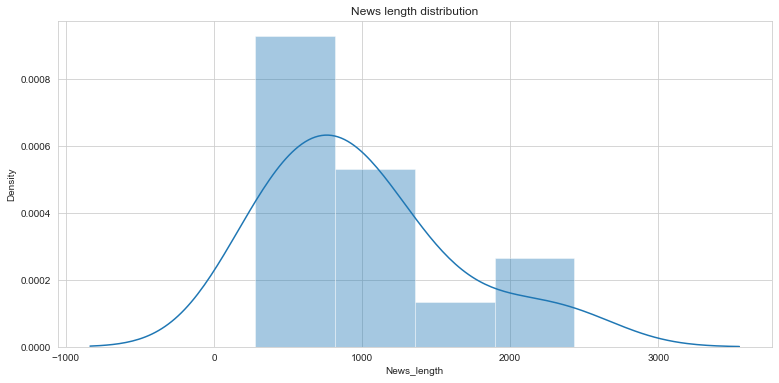

In [9]:
plt.figure(figsize=(12.8,6))
sns.distplot(df['News_length']).set_title('News length distribution');

In [10]:
df['News_length'].describe()

count      14.000000
mean      989.857143
std       628.874068
min       277.000000
25%       529.000000
50%       867.500000
75%      1270.500000
max      2434.000000
Name: News_length, dtype: float64

Let's remove from the 95% percentile onwards to better appreciate the histogram:

In [11]:
quantile_95 = df['News_length'].quantile(0.95)
df_95 = df[df['News_length'] < quantile_95]

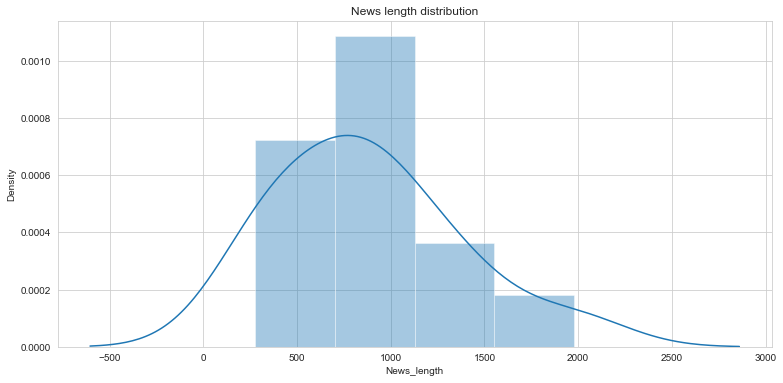

In [12]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['News_length']).set_title('News length distribution');

We can get the number of news articles with more than 10,000 characters:

In [14]:
df_more10k = df[df['News_length'] > 1000]
len(df_more10k)

5

Let's see one:

In [15]:
df_more10k['Content'].iloc[0]

'Promised solutions, emerging problems\n\nMuch of the interest in mobility technology is coming from individuals outside the transport arena. Startups are attracting investors by claiming their technology will solve many of our transport problems. Micromobility companies believe their e-scooters and e-bikes will solve the “first-mile last-mile” problem by enabling people to move quickly and easily between their homes or workplaces and a bus or rail station. While this might work in theory, it depends on having safe and segregated bicycle networks and frequent and widely accessible public transport services. Ride-hailing services might relieve people of the need to own a car. But there is evidence to suggest these services are adding to traffic congestion. That’s because, unlike taxis, more of their time on the road involves travelling without any passengers.Navigation tools (Google Maps, Apple Maps, Waze) have been around longer than most other mobility technologies and are meant make 

It's just a large news article.

Let's now plot a boxplot:

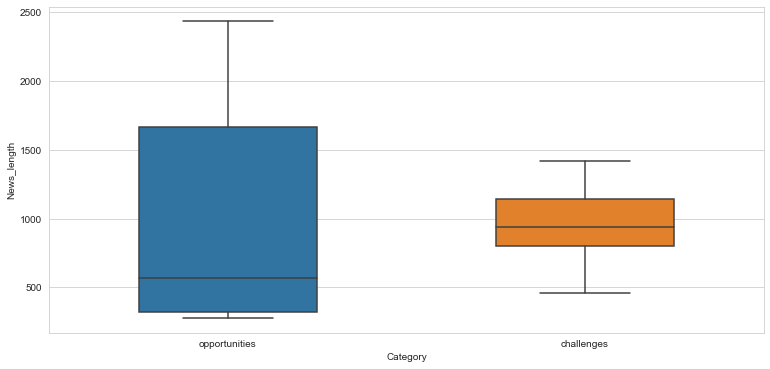

In [16]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='Category', y='News_length', width=.5);

Now, let's remove the larger documents for better comprehension:

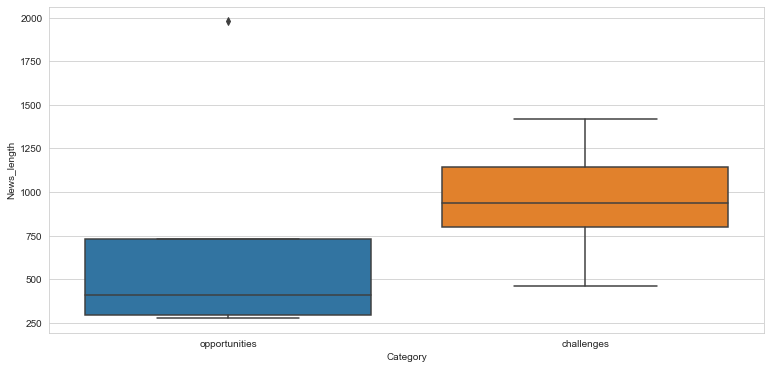

In [17]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='Category', y='News_length');

We can see that, although the length distribution is different for every category, the difference is not too big. If we had way too different lengths between categories we would have a problem since the feature creation process may take into account counts of words. However, when creating the features with TF-IDF scoring, we will normalize the features just to avoid this.

At this point, we cannot do further Exploratory Data Analysis. We'll turn onto the **Feature Engineering** section.

We'll save the dataset:

In [18]:
with open('News_dataset.pickle', 'wb') as output:
    pickle.dump(df, output)